Business Problem

A empresa Top Bank atua na Europa tendo como principal produto uma conta bancária, este produto pode manter o salário do cliente e efetuar pagamentos. Essa conta não tem nenhum custo nos primeiros 12 meses, porém, após esse contra-relógio, o cliente precisa recontratar o banco para os próximos 12 meses e refazer esse processo todos os anos. Recentemente, a equipe de análise notou que a taxa de churn está aumentando.

Como Cientista de Dados, você precisa criar um plano de ação para diminuir o número de clientes churn e mostrar o retorno financeiro da sua solução.
Além disso, você precisará fornecer um relatório relatando o desempenho de seu modelo e o impacto financeiro de sua solução.
Perguntas que o CEO e a equipe do Analytics gostariam de ver em seu relatório:

1. Qual é a atual taxa de Churn do Top Bank?

2. How does the churn rate vary monthly?

3. Qual é o desempenho do modelo na classificação de clientes como churns?

4. Qual é o retorno esperado, em termos de receita, se a empresa utilizar seu modelo para evitar o churn de clientes?


Data Fields


- **RowNumber:** o número de colunas
- **CustomerID:** identificador exclusivo de clientes
- **Surname:** sobrenome do cliente
- **CreditScore:** pontuação de crédito do cliente para o mercado financeiro
- **Geography:** o país do cliente
- **Gender:** o gênero do cliente
- **Age:** a idade do cliente
- **Tenure:** número de anos que o cliente está no banco
- **Balance:** o valor que o cliente tem em sua conta
- **NumOfProducts:** o número de produtos que o cliente comprou
- **HasCrCard:** se o cliente tiver cartão de crédito
- **IsActiveMember:** se o cliente estiver ativo (nos últimos 12 meses)
- **EstimateSalary:** estimativa do salário anual dos clientes
- **Exited:** se o cliente for um churn (variável resposta)

# 0.0 Imports

In [328]:
import inflection 
import warnings
import random

import scikitplot  as skplt
import pandas      as pd
import numpy       as np
import seaborn     as sns
import xgboost     as xgb

from scipy                 import stats as ss
from matplotlib            import pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn                 import ensemble        as en
from lightgbm                import LGBMClassifier
from sklearn                 import linear_model    as lm
from sklearn                 import model_selection as ms
from sklearn                 import preprocessing   as pp
from sklearn                 import neighbors       as nh
from sklearn.metrics         import precision_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from tabulate                import tabulate

warnings.filterwarnings('ignore')

## 0.1 Helper Functions

In [294]:
def jupyter_settings():
        %matplotlib inline
        
        plt.style.use('bmh')
        plt.rcParams['figure.figsize'] = [25 , 12]
        plt.rcParams['font.size'] = 24
        
        display( HTML( '<style>.container { width:100% !important; }</style>') )
        pd.options.display.max_columns = None
        pd.options.display.max_rows = None
        pd.set_option( 'display.expand_frame_repr', False )
        
        sns.set()
        
def cramer_v( x, y ):
        cm = pd.crosstab( x, y ).to_numpy()
        n = cm.sum()
        r, k = cm.shape
        
        chi2 = ss.chi2_contingency( cm )[0]
        chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
        
        kcorr = k - (k-1)**2/(n-1)
        rcorr = r - (r-1)**2/(n-1)
        
        return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )
    
    
def cross_validation(data, model, name_model, n_splits, n_repeats, top_k):
    X = data.drop('exited',axis=1)
    y = data['exited']
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    i = 1
    metrics_k = pd.DataFrame()
    
    for train_index, test_index in cv.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
        print ('\nKFold Number: {}'.format( i ) )
        i+=1
        
        #print('training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
        
        #model training
        ml_model = model.fit(X_train,y_train)
        
        #prediction
        yhat = ml_model.predict_proba(X_val)
        
        #performance
        result_model = table_analysis(y_val,yhat)
        #metrics_k = metrics_k.append(precision_recall_at_k(result_model,top_k))
        metrics_k = pd.concat([metrics_k,precision_recall_at_k(result_model,top_k)],axis=0)
        
    
    
    real_performance = pd.DataFrame({
        #'Name_Model': name_model,
        'Mean_Precision_at_k' : str((np.round((metrics_k['precision_at_k'].mean()),5)))+ '+/-'+str((np.round((metrics_k['precision_at_k'].std()),5))),
        'Mean_Recall_at_k': str((np.round((metrics_k['recall_at_k'].mean()),5)))+ '+/-'+str((np.round((metrics_k['recall_at_k'].std()),5)))
    }, index = [name_model])        
        
    
    return real_performance

def table_analysis(y_val,yhat):
    table = pd.DataFrame(y_val)
    table['customer_id'] = y_val.index + 1
    table['predict_score'] = yhat[:,1].tolist()
    table = table.sort_values('predict_score',ascending=False)
    table = table.reset_index(drop=True)
    table['ranking'] = table.index + 1
    table['acc_pred_score'] = table['exited'].cumsum()/table['exited'].sum()
    table['base'] = table['ranking']/len(table)
    table['baseline'] = table['base'] 
    table['lift'] = table['acc_pred_score'] / table['baseline']
    table['precision_at_k'] = table['exited'].cumsum()/table['ranking']
    table['recall_at_k'] = table['exited'].cumsum()/table['exited'].sum()
    order_cols = ['customer_id','exited','predict_score','ranking','acc_pred_score','base','baseline','lift','precision_at_k','recall_at_k']
    table = table[order_cols]
    
    return table

def precision_recall_at_k (table, k=100):
    #data = data.sort_values('predict_score',ascending=False)
    #data = data.reset_index(drop=True)
    #data['ranking'] = data.index+1
    table['precision_at_k'] = table['exited'].cumsum()/table['ranking']
    table['recall_at_k'] = table['exited'].cumsum()/table['exited'].sum()
    
    return pd.DataFrame({'precision_at_k':table.loc[k-1,'precision_at_k'],'recall_at_k': table.loc[k-1,'recall_at_k']},index=[k])

def precision_recall_at_k_2 (table, k=100):
    #data = data.sort_values('predict_score',ascending=False)
    #data = data.reset_index(drop=True)
    #data['ranking'] = data.index+1
    table['precision_at_k'] = table['exited'].cumsum()/table['ranking']
    table['recall_at_k'] = table['exited'].cumsum()/table['exited'].sum()
    
    return ({table.loc[k-1,'precision_at_k'],table.loc[k-1,'recall_at_k']})

In [44]:
jupyter_settings()

## 0.2 Import dataset

In [3]:
data_raw = pd.read_csv('C:/Users/kaka/Projetos_DS/client-churn/data/raw/churn.csv')

# 1.0 Data Description

In [73]:
df1 = data_raw.copy()

## 1.1 Data Dimension

In [74]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 10000
Number of Columns: 14


## 1.2 Data Columns Rename

In [75]:
cols_old = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
            'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
            'IsActiveMember', 'EstimatedSalary', 'Exited']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new



In [76]:
df1 = df1.drop('row_number', axis=1)

## 1.3 Data Types

In [77]:
df1.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Data Check NA

In [78]:
df1.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Data Descriptive 

In [82]:
num_attributes = df1[['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products']]
cat_attributes = df1[['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited', 'surname']]

### 1.5.1 Numerical Attributes

In [83]:
#Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes,', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m    

,"attributes,",min,max,range,mean,median,std,skew,kurtosis
0,customer_id,15565701.0,15815690.00,249989.00,1.569094e+07,15690738.00,71932.589224,0.001149,-1.196113
1,credit_score,350.0,850.00,500.00,6.505288e+02,652.00,96.648466,-0.071607,-0.425726
2,age,18.0,92.00,74.00,3.892180e+01,37.00,10.487282,1.011320,1.395347
3,tenure,0.0,10.00,10.00,5.012800e+00,5.00,2.892030,0.010991,-1.165225
4,balance,0.0,250898.09,250898.09,7.648589e+04,97198.54,62394.285254,-0.141109,-1.489412
5,num_of_products,1.0,4.00,3.00,1.530200e+00,1.00,0.581625,0.745568,0.582981


### 1.5.2 Categorical Attributes

In [85]:
cat_attributes.apply(lambda x: x.unique().shape[0])

geography              3
gender                 2
has_cr_card            2
is_active_member       2
exited                 2
surname             2932
dtype: int64

In [86]:
#gender
aux = pd.DataFrame({'absolute': cat_attributes['gender'].value_counts(), 'percent %': cat_attributes['gender'].value_counts(normalize = True) * 100 })
aux

,absolute,percent %
Male,5457,54.57
Female,4543,45.43


In [87]:
#geography
aux = pd.DataFrame({'absolute': cat_attributes['geography'].value_counts(), 'percent %': cat_attributes['geography'].value_counts(normalize = True) * 100 })
aux

,absolute,percent %
France,5014,50.14
Germany,2509,25.09
Spain,2477,24.77


In [88]:
#has_cr_card
aux = pd.DataFrame({'absolute': cat_attributes['has_cr_card'].value_counts(), 'percent %': cat_attributes['has_cr_card'].value_counts(normalize = True) * 100 })
aux

,absolute,percent %
1,7055,70.55
0,2945,29.45


In [89]:
#is_active_member
aux = pd.DataFrame({'absolute': cat_attributes['is_active_member'].value_counts(), 'percent %': cat_attributes['is_active_member'].value_counts(normalize = True) * 100 })
aux

,absolute,percent %
1,5151,51.51
0,4849,48.49


In [90]:
#exited
aux = pd.DataFrame({'absolute': cat_attributes['exited'].value_counts(), 'percent %': cat_attributes['exited'].value_counts(normalize = True) * 100 })
aux

,absolute,percent %
0,7963,79.63
1,2037,20.37


# 2.0 Feature Engineering

In [91]:
df2 = df1.copy()

# 3.0 Data Filtering

In [92]:
df3 = df2.copy()

# 4.0 EDA

In [93]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

<AxesSubplot:xlabel='exited'>

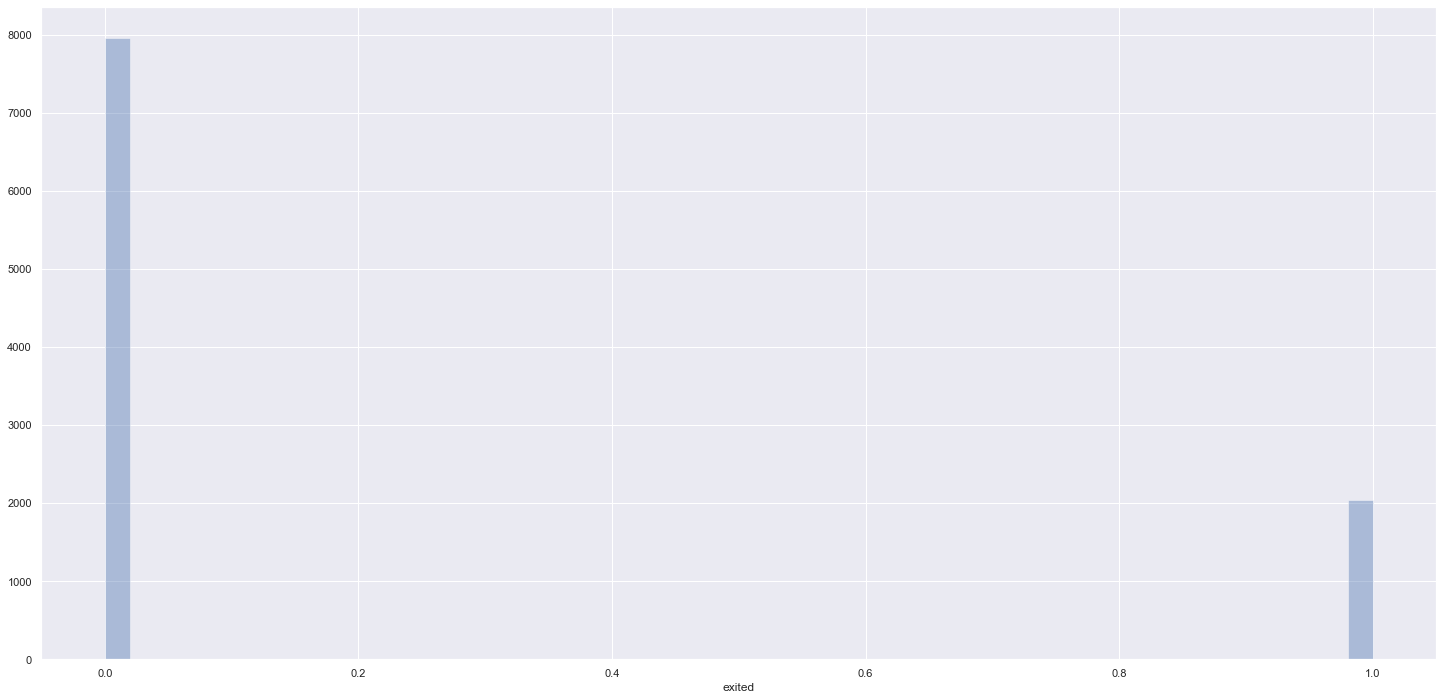

In [94]:
sns.distplot(df4['exited'], kde=False)

### 4.1.2 Numerical Variable

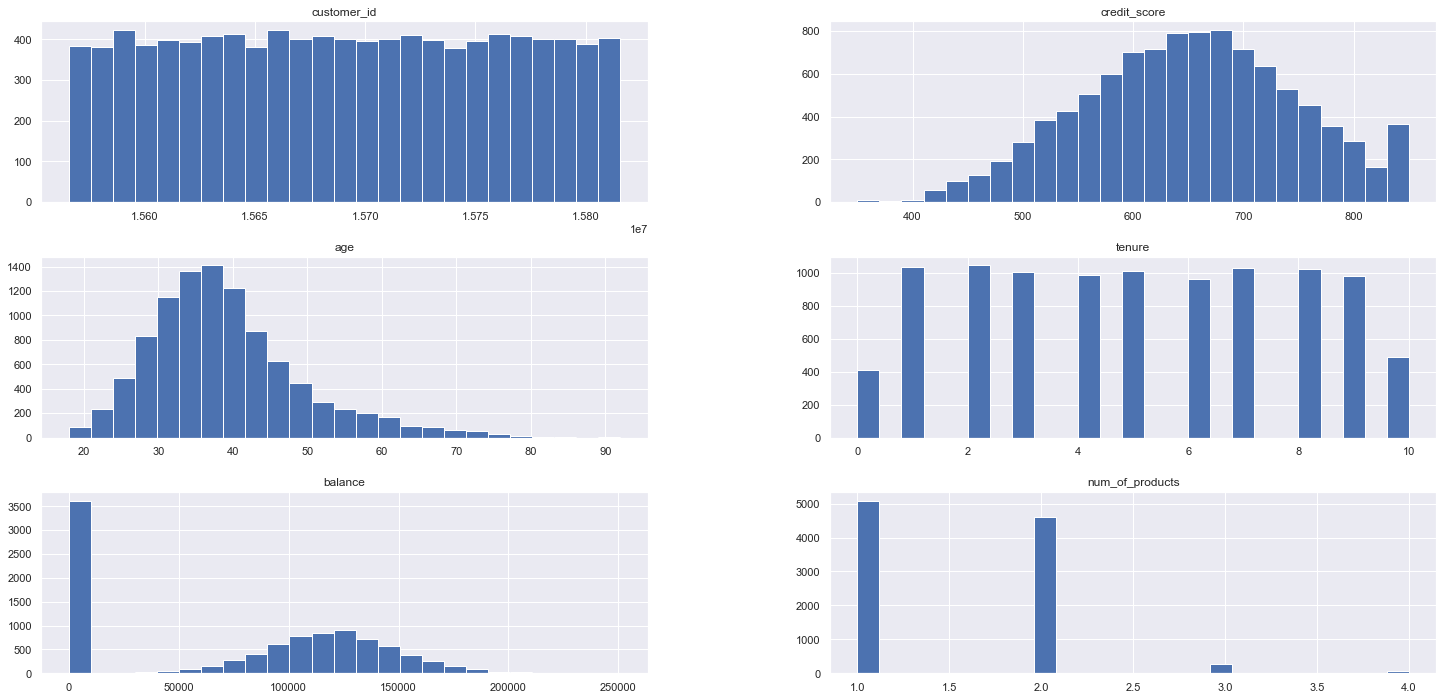

In [95]:
num_attributes.hist( bins=25 );

### 4.1.3 Categorical Variable

<AxesSubplot:xlabel='is_active_member', ylabel='count'>

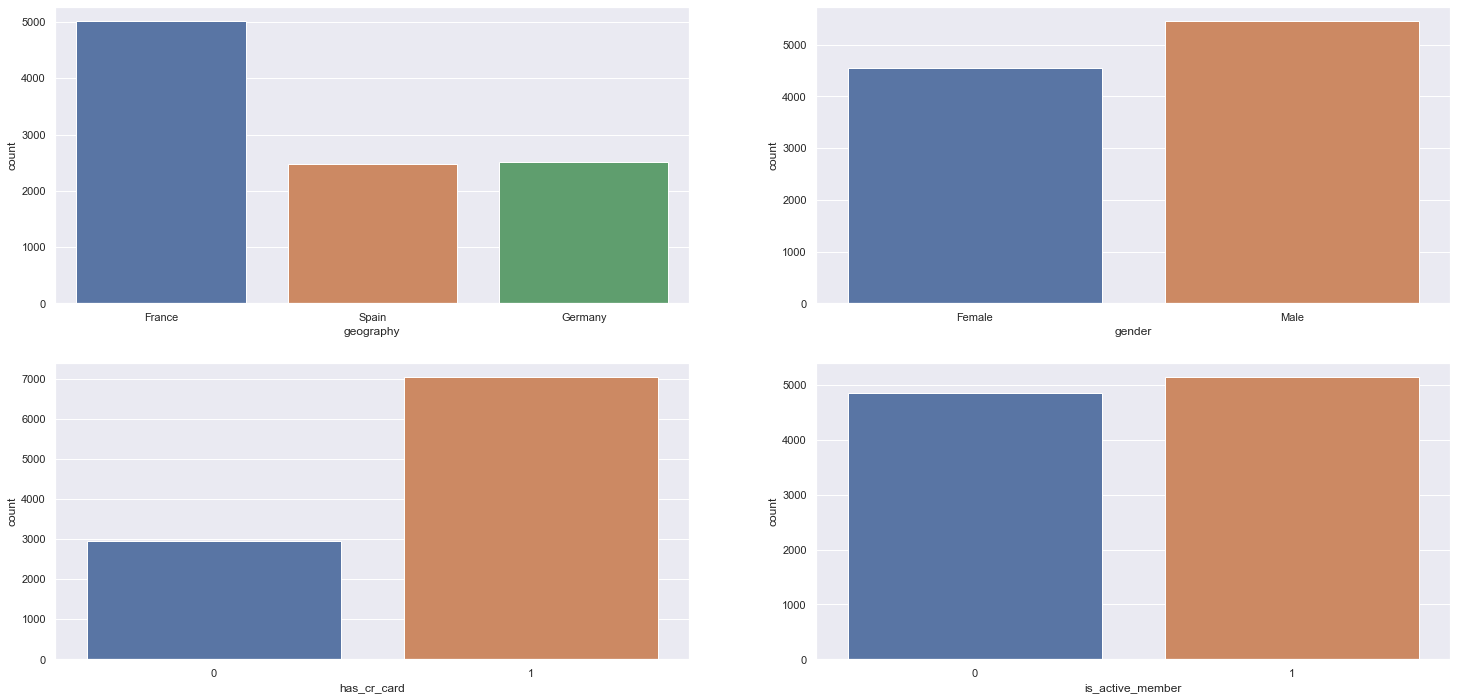

In [96]:
plt.subplot(2, 2, 1)
sns.countplot(df4['geography'])

plt.subplot(2, 2, 2)
sns.countplot(df4['gender'])

plt.subplot(2, 2, 3)
sns.countplot(df4['has_cr_card'])

plt.subplot(2, 2, 4)
sns.countplot(df4['is_active_member'])

## 4.2 Análise Bivariada

### 4.2.1 H1 Clientes idosos têm mais tendência a serem churn.

**True** Clientes com maior idade, tendem a serem churn

<AxesSubplot:xlabel='age', ylabel='Density'>

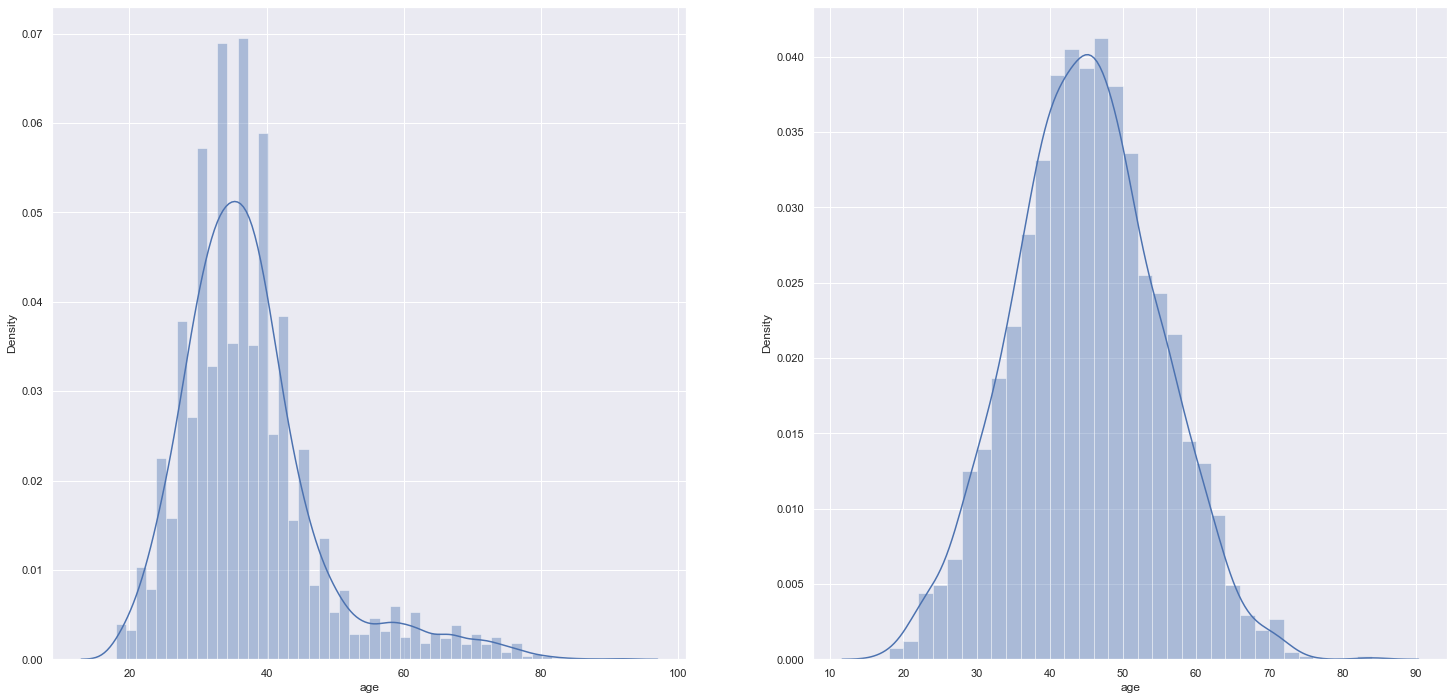

In [145]:
plt.subplot(1, 2, 1)
aux = (df4[df4['exited'] == 0]['age'])
sns.distplot(aux, kde=True)

plt.subplot(1, 2, 2)
aux = (df4[df4['exited'] == 1]['age'])
sns.distplot(aux, kde=True)

<AxesSubplot:xlabel='age', ylabel='exited'>

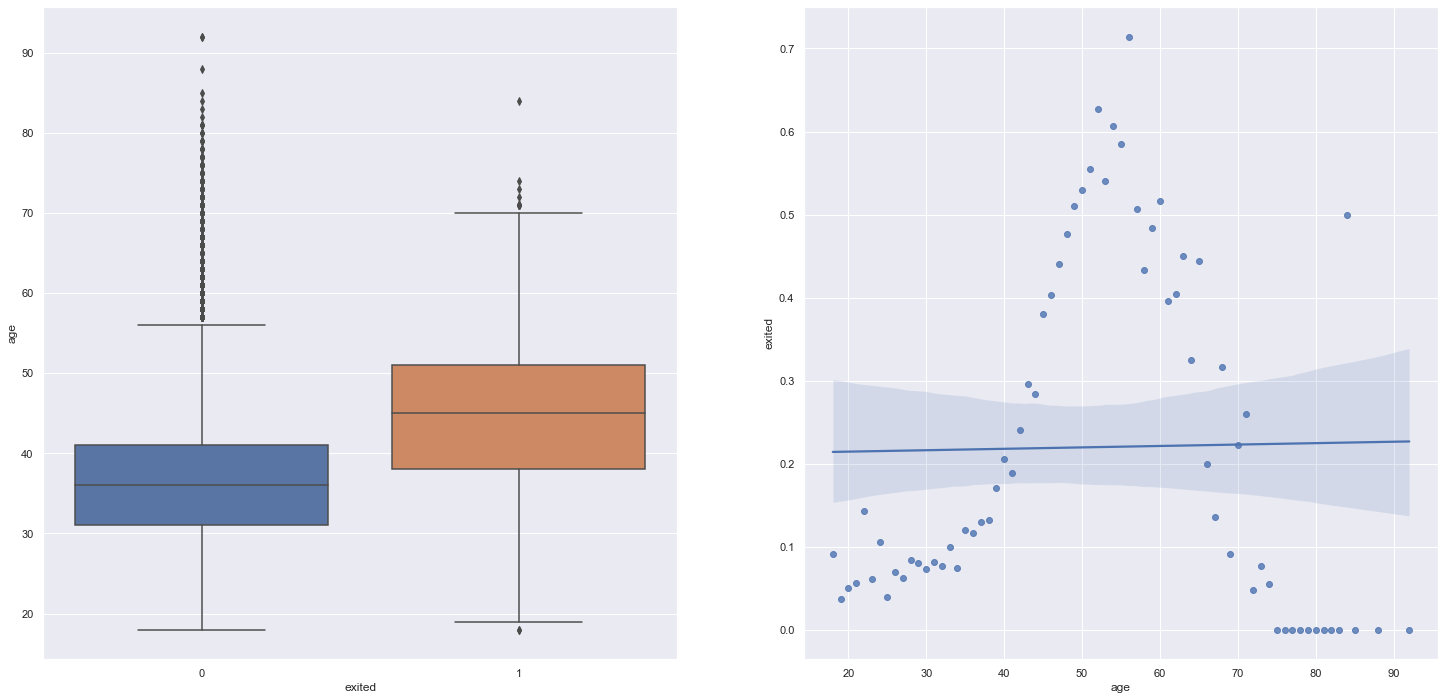

In [151]:
plt.subplot(1, 2, 1)
aux = df4[['age', 'exited']]
sns.boxplot(x='exited', y='age', data=aux)


plt.subplot(1, 2, 2)
aux = df4[['age', 'exited']].groupby('age').mean().reset_index()
sns.regplot(x='age', y='exited', data=aux)

### 4.2.2 H2 Homens tem mais tendencia a entrar em churn

**True** Mulheres tem mais tendencia a entrar em churn

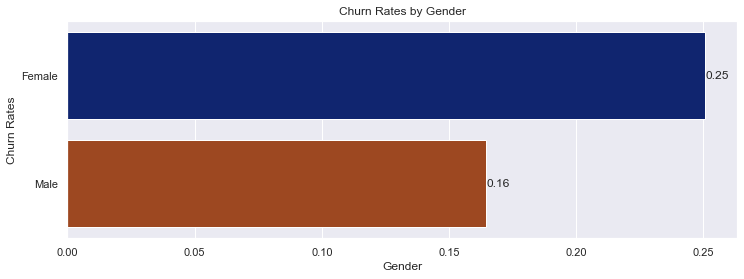

In [149]:
aux = df4[['gender', 'exited']].groupby('gender').mean().reset_index()

# display graph
plt.figure(figsize=(12,4))
graph = sns.barplot(y='gender', x='exited', data=aux, palette='dark');
graph.bar_label(graph.containers[0], fmt='%.2f');
plt.xlabel('Gender');
plt.ylabel('Churn Rates');
plt.title('Churn Rates by Gender');

### 4.2.3 H3 Clientes com mais de 5 anos de permanência têm uma taxa de churn menor

**False** Os clientes tem a mesma taxa de churn independente da permanencia

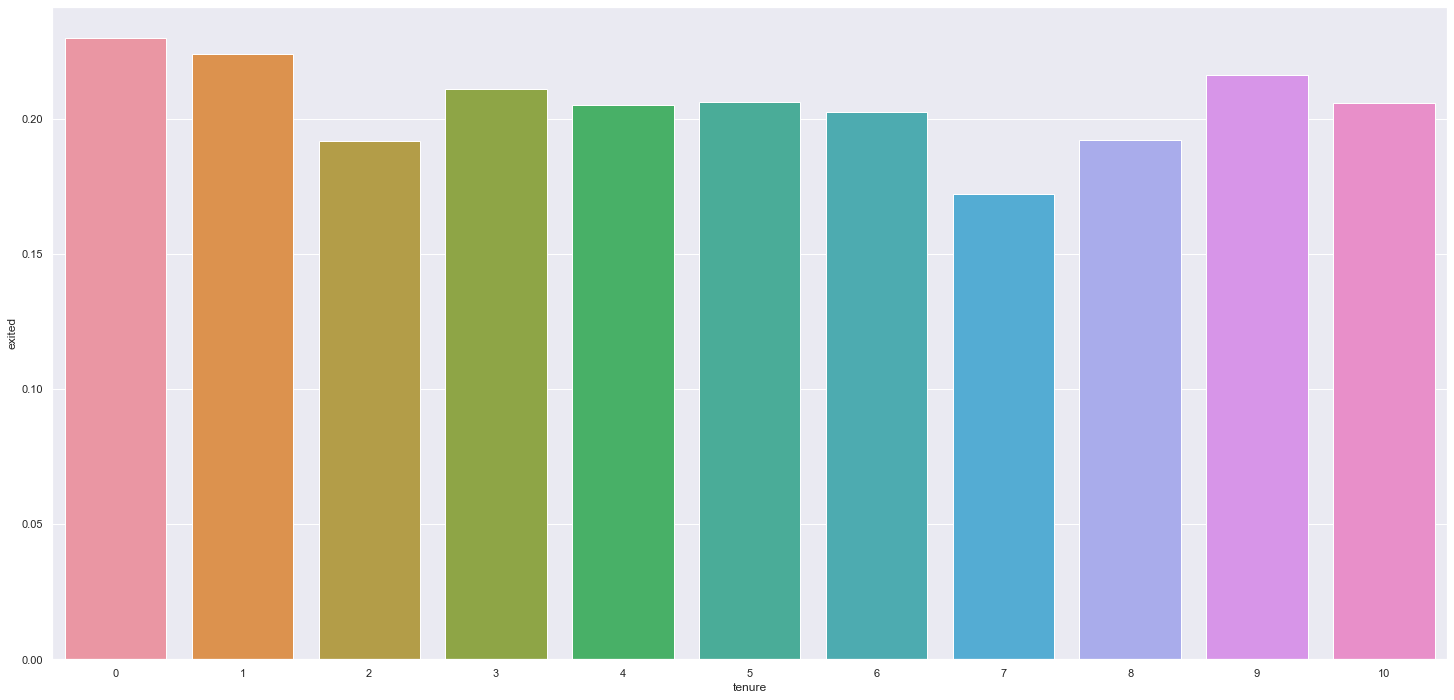

In [152]:
aux = df4[['exited', 'tenure']].groupby('tenure').mean().reset_index()
sns.barplot(x='tenure', y='exited', data=aux);

<AxesSubplot:xlabel='tenure', ylabel='Density'>

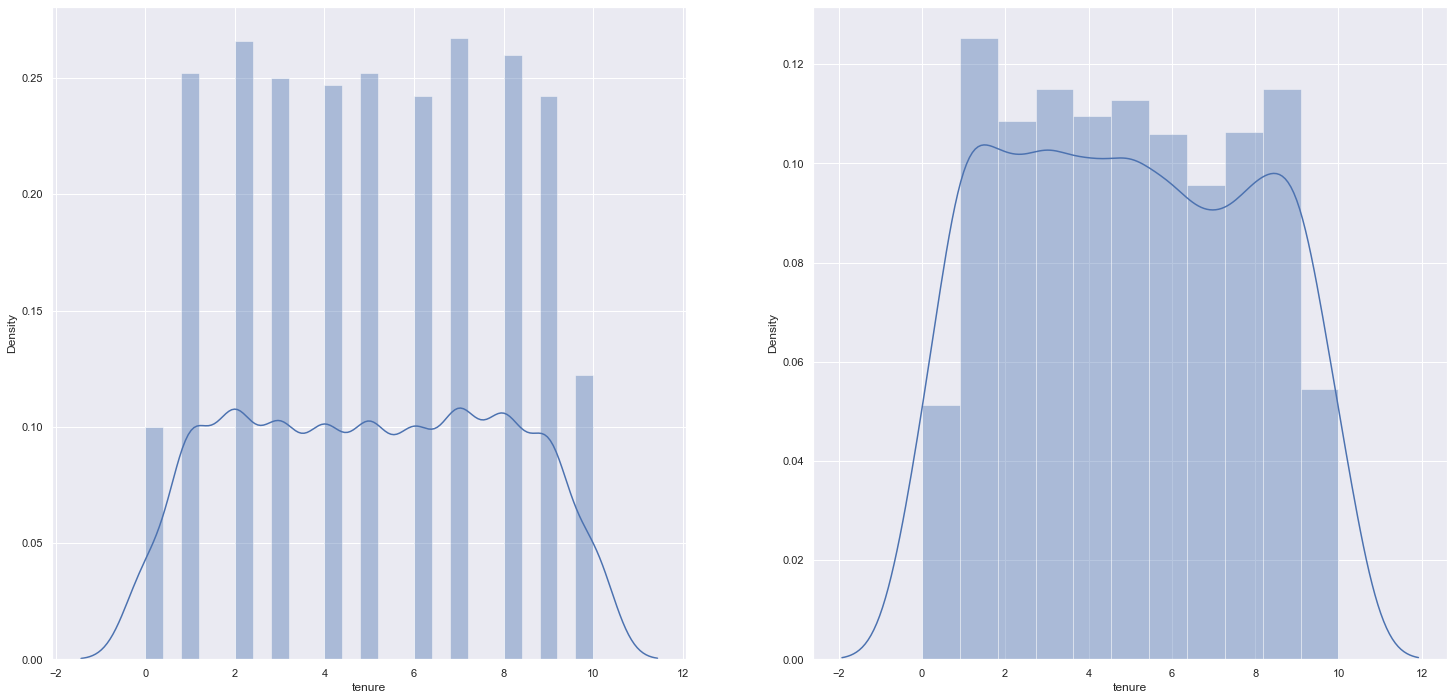

In [154]:
plt.subplot(1, 2, 1)
aux = (df4[df4['exited'] == 0]['tenure'])
sns.distplot(aux, kde=True)

plt.subplot(1, 2, 2)
aux = (df4[df4['exited'] == 1]['tenure'])
sns.distplot(aux, kde=True)

### 4.2.4 H4 Clientes com maior score de crédito tem menor chance de churn

**Verdadeiro** Os clientes coma menores taxas de crédito tem maior chance de churn

<AxesSubplot:xlabel='credit_score', ylabel='exited'>

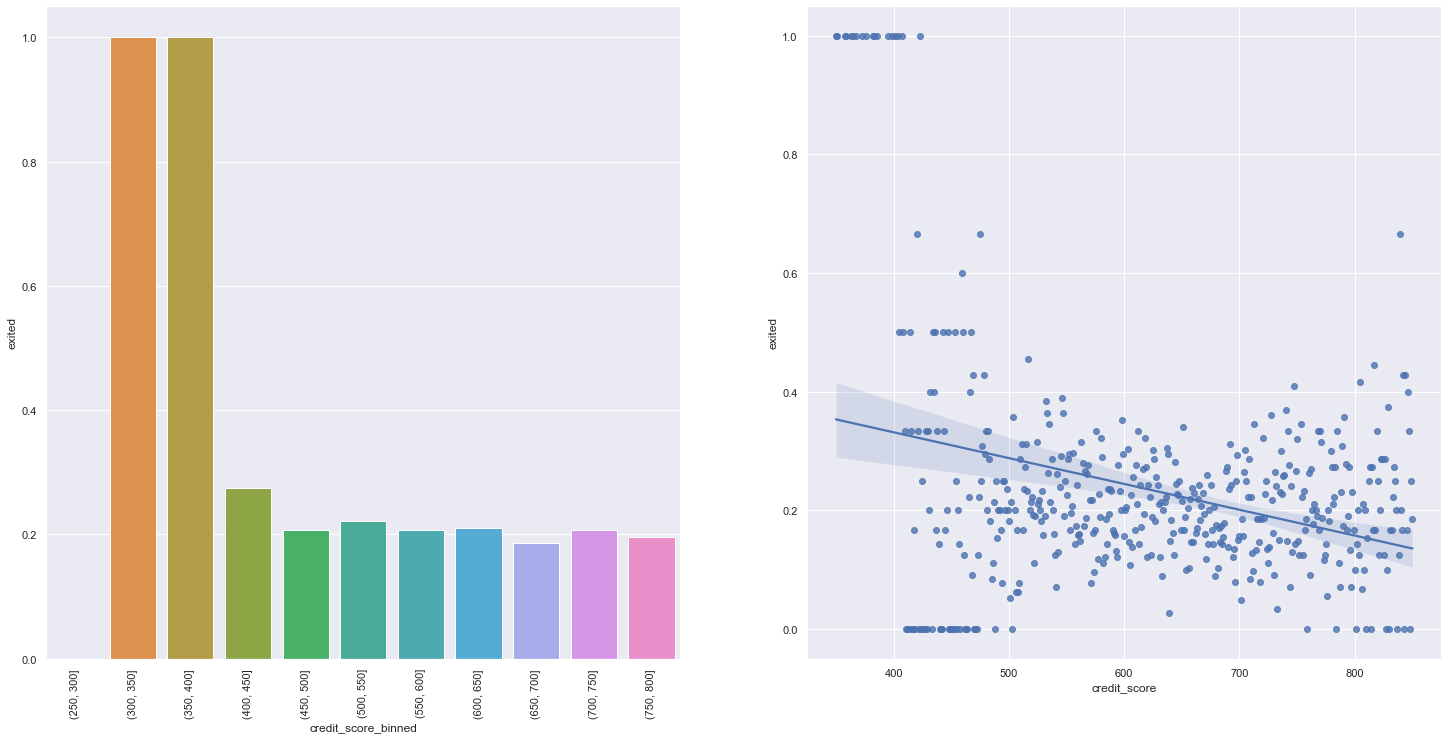

In [173]:
aux = df4[['exited', 'credit_score']].groupby('credit_score').mean().reset_index()

plt.subplot(1, 2, 1)
bins = list(np.arange(250, 850, 50))
aux['credit_score_binned'] = pd.cut(aux['credit_score'], bins=bins)
aux2 = aux[['exited', 'credit_score_binned']].groupby('credit_score_binned').mean().reset_index()
sns.barplot(x='credit_score_binned', y='exited', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 2, 2)
sns.regplot(x='credit_score', y='exited', data=aux)

### 4.2.5 H5 Quanto maior a quantidade de produtos, menor a taxa de churn

**False** Quanto maior a quantidade de produtos, maior a probabilidade de churn

<AxesSubplot:>

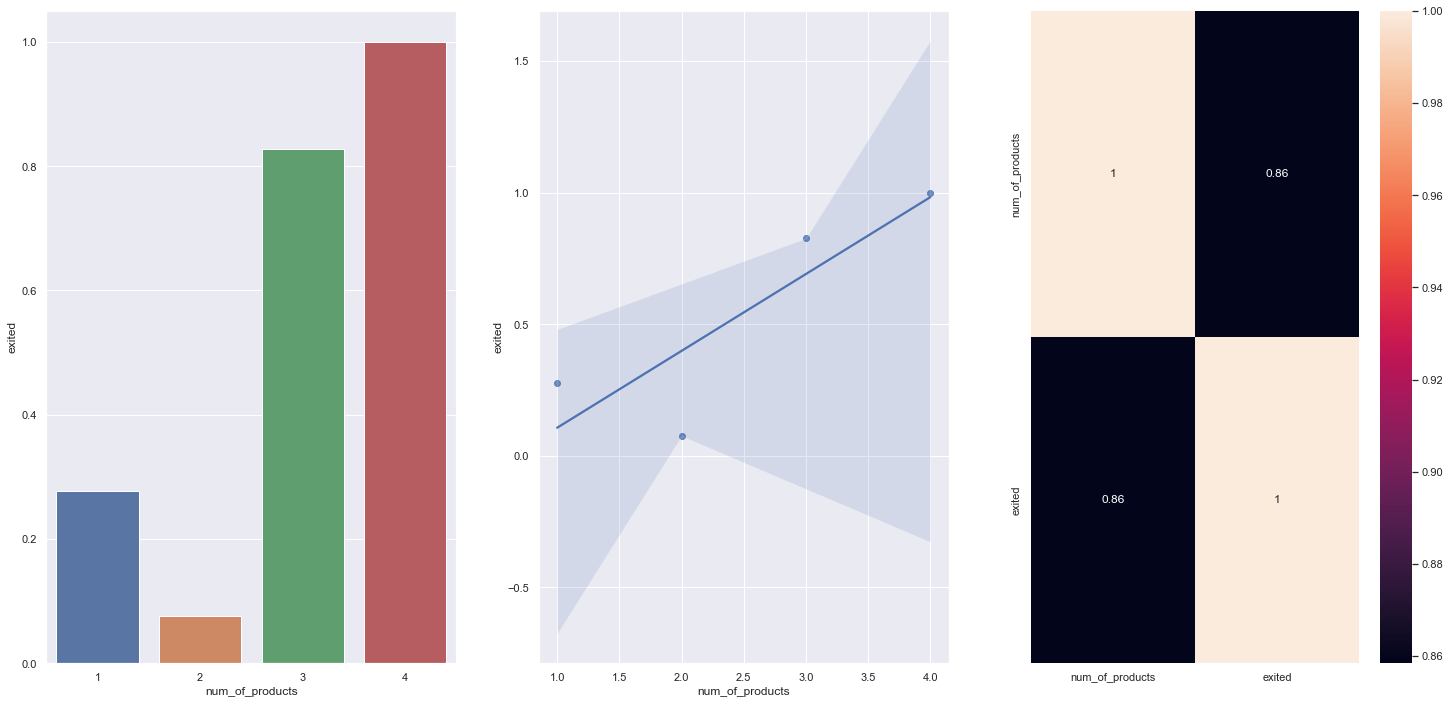

In [171]:
aux = df4[['num_of_products', 'exited']].groupby('num_of_products').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='num_of_products', y='exited', data=aux)

plt.subplot(1, 3, 2)
sns.regplot(x='num_of_products', y='exited', data=aux)

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

### 4.2.5 H6 Clientes com maior valor em conta tem menor chance de entrar em churn

**False** Os clientes com maior valor em conta tem maior chance de churn

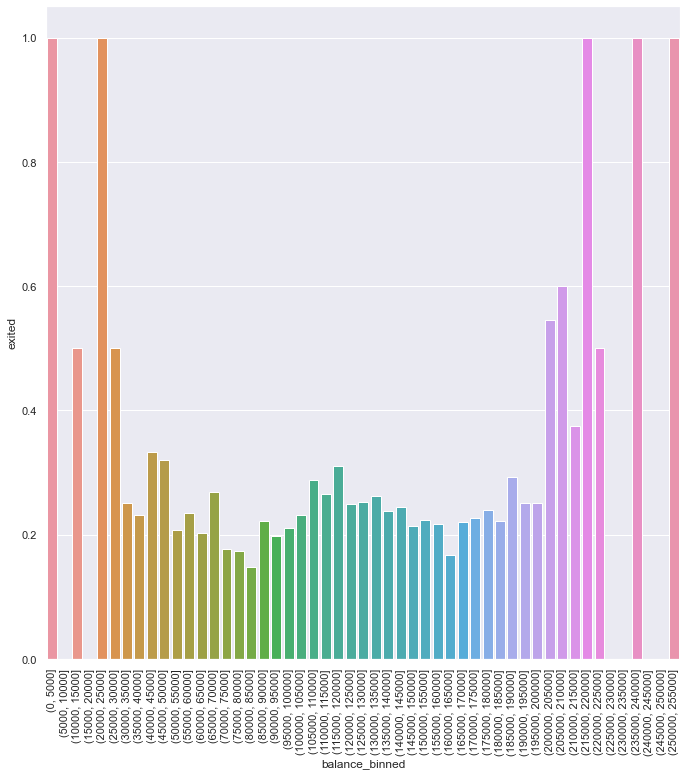

In [188]:
aux = df4[['balance', 'exited']].groupby('balance').mean().reset_index()

plt.subplot(1, 2, 1)
bins = list(np.arange(0, 260000, 5000))
aux['balance_binned'] = pd.cut(aux['balance'], bins=bins)
aux2 = aux[['exited', 'balance_binned']].groupby('balance_binned').mean().reset_index()
sns.barplot(x='balance_binned', y='exited', data=aux2);
plt.xticks(rotation=90);

## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

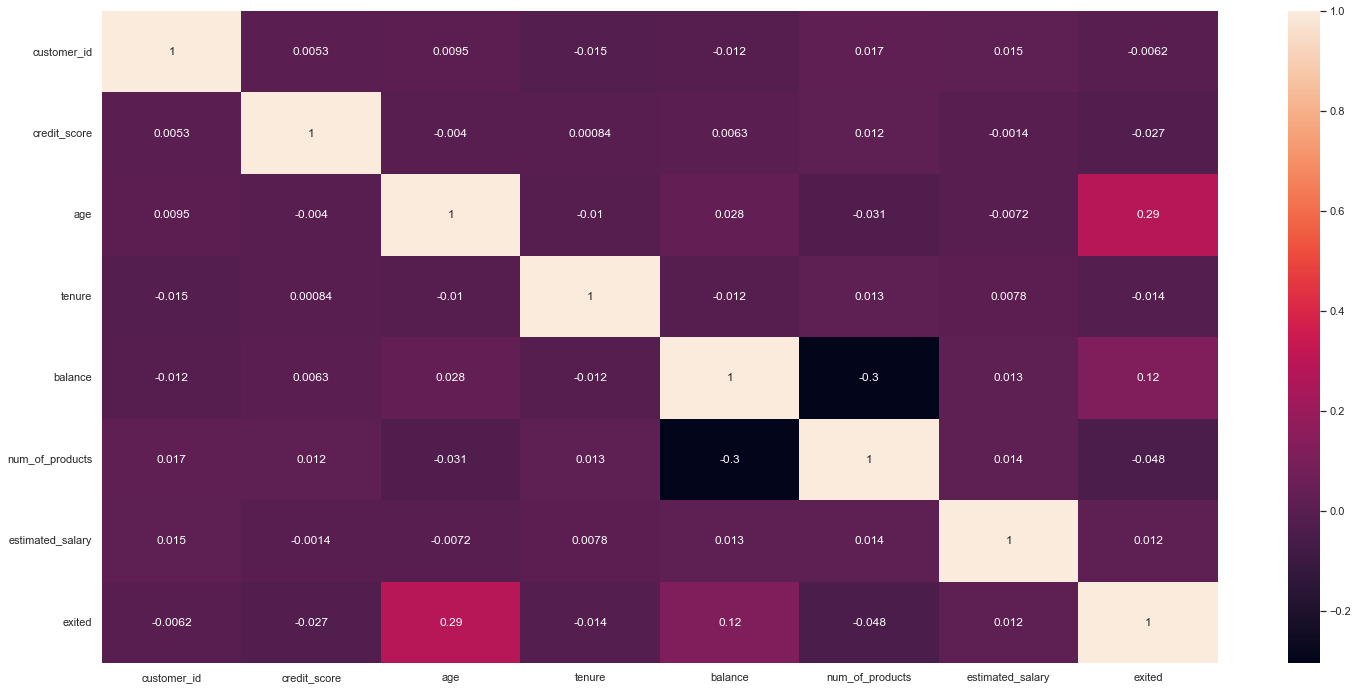

In [210]:
num_attributes = df1[['customer_id', 'credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary', 'exited' ]]

correlation = num_attributes.corr(method='pearson')

sns.heatmap(correlation, annot=True);

### 4.3.1 Categorical Attributes

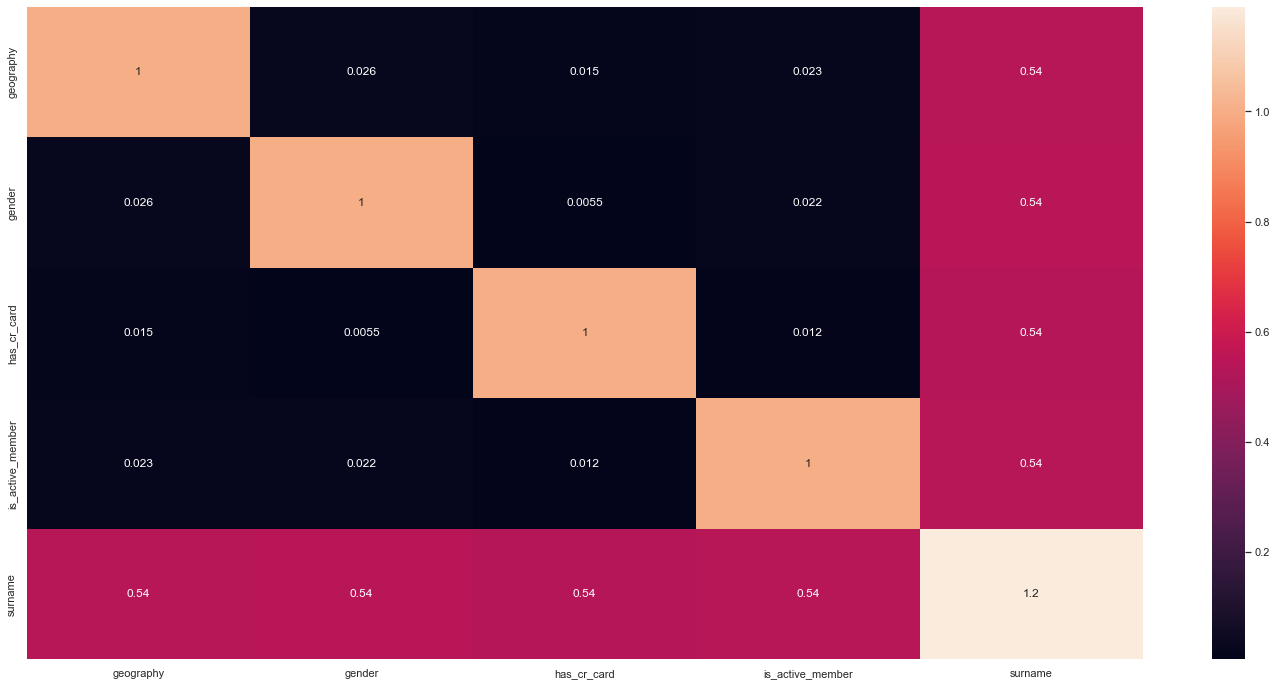

In [202]:
cat_attributes = df4[['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited','surname']]

#only categorical data
a = cat_attributes

#calculate cramer V
a1 = cramer_v(a['geography'], a['geography'])
a2 = cramer_v(a['geography'], a['gender'])
a3 = cramer_v(a['geography'], a['has_cr_card'])
a4 = cramer_v(a['geography'], a['is_active_member'])
a5 = cramer_v(a['geography'], a['surname'])

a6   = cramer_v(a['gender'], a['geography'])
a7   = cramer_v(a['gender'], a['gender'])
a8   = cramer_v(a['gender'], a['has_cr_card'])
a9   = cramer_v(a['gender'], a['is_active_member'])
a10  = cramer_v(a['gender'], a['surname'])

a11  = cramer_v(a['has_cr_card'], a['geography'])
a12  = cramer_v(a['has_cr_card'], a['gender'])
a13  = cramer_v(a['has_cr_card'], a['has_cr_card'])
a14  = cramer_v(a['has_cr_card'], a['is_active_member'])
a15  = cramer_v(a['has_cr_card'], a['surname'])

a16  = cramer_v(a['is_active_member'], a['geography'])
a17  = cramer_v(a['is_active_member'], a['gender'])
a18  = cramer_v(a['is_active_member'], a['has_cr_card'])
a19  = cramer_v(a['is_active_member'], a['is_active_member'])
a20  = cramer_v(a['is_active_member'], a['surname'])

a21  = cramer_v(a['surname'], a['geography'])
a22  = cramer_v(a['surname'], a['gender'])
a23  = cramer_v(a['surname'], a['has_cr_card'])
a24  = cramer_v(a['surname'], a['is_active_member'])
a25  = cramer_v(a['surname'], a['surname'])

#final dataset
d = pd.DataFrame({'geography': [a1, a2, a3, a4, a5],
                  'gender': [a6, a7, a8, a9, a10],
                  'has_cr_card': [a11, a12, a13, a14, a15],
                  'is_active_member': [a16, a17, a18, a19, a20],
                  'surname':[a21, a22, a23, a24, a25]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 Data Preparation

In [265]:
df5 = df4.copy()

In [266]:
y_train = df5['exited'].copy()

In [267]:
mms= MinMaxScaler()

In [268]:
#Numerical preparation

df5['credit_score'] = mms.fit_transform(df5[['credit_score']].values)

df5['age'] = mms.fit_transform(df5[['age']].values)

df5['tenure'] = mms.fit_transform(df5[['tenure']].values)

df5['balance'] = mms.fit_transform(df5[['balance']].values)

df5['estimated_salary'] = mms.fit_transform(df5[['balance']].values)

df5['num_of_products'] = mms.fit_transform(df5[['balance']].values)

In [269]:
#categorical preparation

df5['gender'] = df5['gender'].map( {'Female': 0, 'Male': 1} ).astype('int64')


target_encode_geography = df5.groupby( 'geography' )['exited'].mean()
df5.loc[:, 'geography'] = df5['geography'].map( target_encode_geography )

In [270]:
target_encode_surname = df5.groupby( 'surname' )['exited'].mean()
df5.loc[:, 'surname'] = df5['surname'].map( target_encode_surname )

In [257]:
df5.head()

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,1.000000,0.538,0.161548,0,0.324324,0.2,0.000000,0.000000,1,1,0.000000,1
1,15647311,0.117647,0.516,0.166734,0,0.310811,0.1,0.334031,0.334031,0,1,0.334031,0
2,15619304,0.250000,0.304,0.161548,0,0.324324,0.8,0.636357,0.636357,1,0,0.636357,1
3,15701354,0.214286,0.698,0.161548,0,0.283784,0.1,0.000000,0.000000,0,0,0.000000,0
4,15737888,0.100000,1.000,0.166734,0,0.337838,0.2,0.500246,0.500246,1,1,0.500246,0


# 6.0 Feature Selection

In [245]:
x_train_n = df5.drop( ['customer_id', 'exited'], axis=1 )
y_train_n = y_train.values

In [259]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

x_train_n = df5.drop( ['customer_id', 'exited'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
            feature  importance
0           surname    0.322129
0               age    0.193201
0      credit_score    0.101433
0            tenure    0.083184
0   num_of_products    0.063215
0  estimated_salary    0.063060
0           balance    0.062776
0         geography    0.040840
0  is_active_member    0.030521
0       has_cr_card    0.022167
0            gender    0.017474


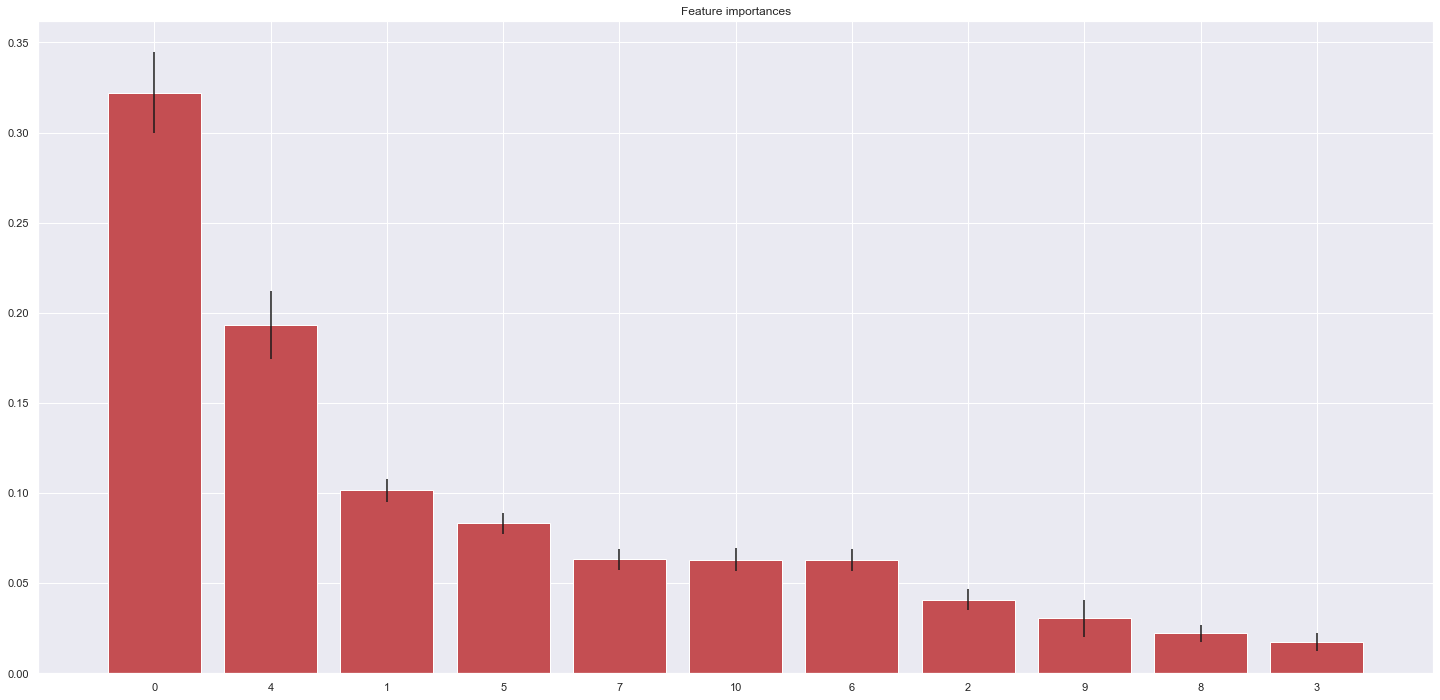

In [260]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0 Machine Learning Model

In [271]:
cols_selected = ['surname', 'credit_score', 'geography', 'gender', 'age',
                 'tenure', 'balance', 'num_of_products', 'has_cr_card',
                 'is_active_member', 'estimated_salary']

cols_selected_full = ['surname', 'credit_score', 'geography', 'gender', 'age',
                      'tenure', 'balance', 'num_of_products', 'has_cr_card',
                      'is_active_member', 'estimated_salary', 'exited']

In [272]:
X = df5.drop( 'exited', axis=1 )
y = df5['exited'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

In [274]:
x_train = df5[ cols_selected ]

x_val = x_validation[ cols_selected ]
y_val = y_validation

In [280]:
df7 = df5[cols_selected_full]

## 7.1 KNN Classifier

In [292]:
params = {
    'n_neighbors':  [3,5,8,15],
    'weights':  ['uniform', 'distance'], 
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20,30,40],
    'p': [1,2]
}
MAX_EVAL = 5

In [300]:
knn_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    knn_model =  nh.KNeighborsClassifier( n_neighbors = hp['n_neighbors'],
                                          weights = hp['weights'],
                                          algorithm= hp['algorithm'],
                                          leaf_size= hp['leaf_size'],
                                          p = hp['p'])
         
    knn_cv = cross_validation(df7, knn_model,'KNN Classifier - '+str(i),5,2,200)
    
    knn_m = knn_m.append(knn_cv)
    print(knn_m)
    
    
knn_m

{'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 2}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                   Mean_Precision_at_k   Mean_Recall_at_k
KNN Classifier - 0     0.7575+/-0.0243  0.46246+/-0.01507
{'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 30, 'p': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                   Mean_Precision_at_k   Mean_Recall_at_k
KNN Classifier - 0     0.7575+/-0.0243  0.46246+/-0.01507
KNN Classifier - 1     0.709+/-0.02355  0.43285+/-0.01468
{'n_neighbors': 3, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 20, 'p': 2}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold

,Mean_Precision_at_k,Mean_Recall_at_k
KNN Classifier - 0,0.7575+/-0.0243,0.46246+/-0.01507
KNN Classifier - 1,0.709+/-0.02355,0.43285+/-0.01468
KNN Classifier - 2,0.7165+/-0.01651,0.43743+/-0.01037
KNN Classifier - 3,0.717+/-0.02251,0.43774+/-0.01423
KNN Classifier - 4,0.749+/-0.01449,0.45726+/-0.00842


In [301]:
#find best k
Ks = 15

mean_rcc = np.zeros((Ks-1))

for n in range(9,Ks):
    
    #Train Model and Predict  
    knn_model = nh.KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat = knn_model.predict(x_val)
    mean_rcc[n-1] = balanced_accuracy_score(y_validation, yhat)

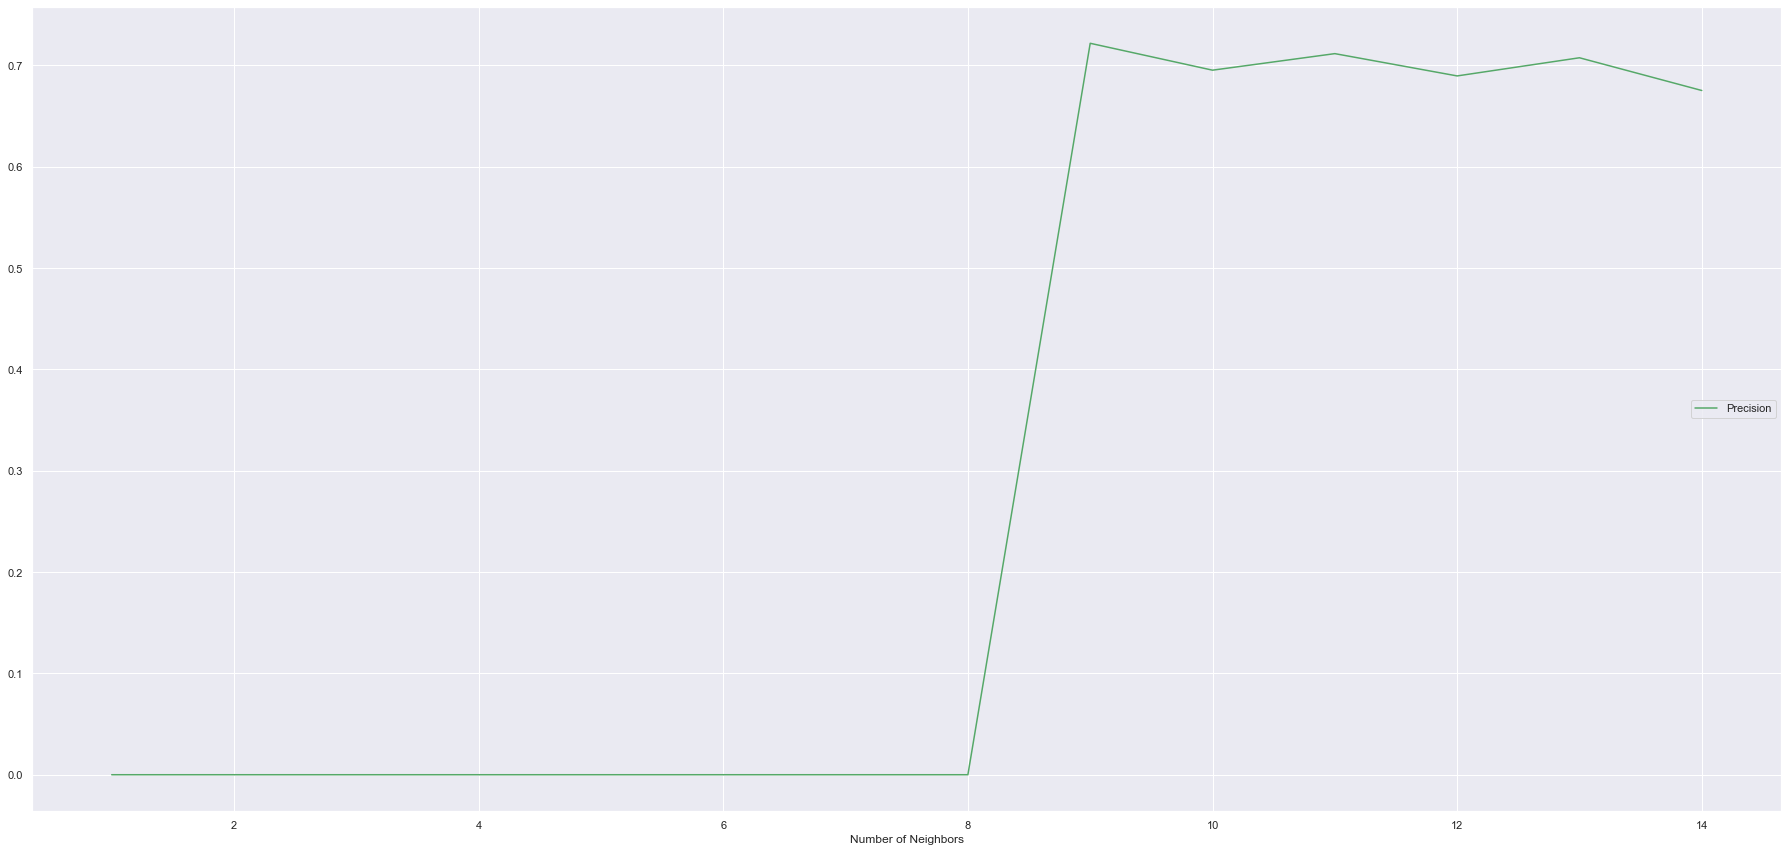

In [302]:
plt.plot(range(1,Ks),mean_rcc,'g')
plt.legend(('Precision', ), loc = 'center right' )
plt.xlabel('Number of Neighbors')
plt.tight_layout()
plt.show()

In [303]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=10 )

# model training
knn_model.fit( x_train, y_train )

# model prediction
yhat_knn = knn_model.predict_proba( x_val )

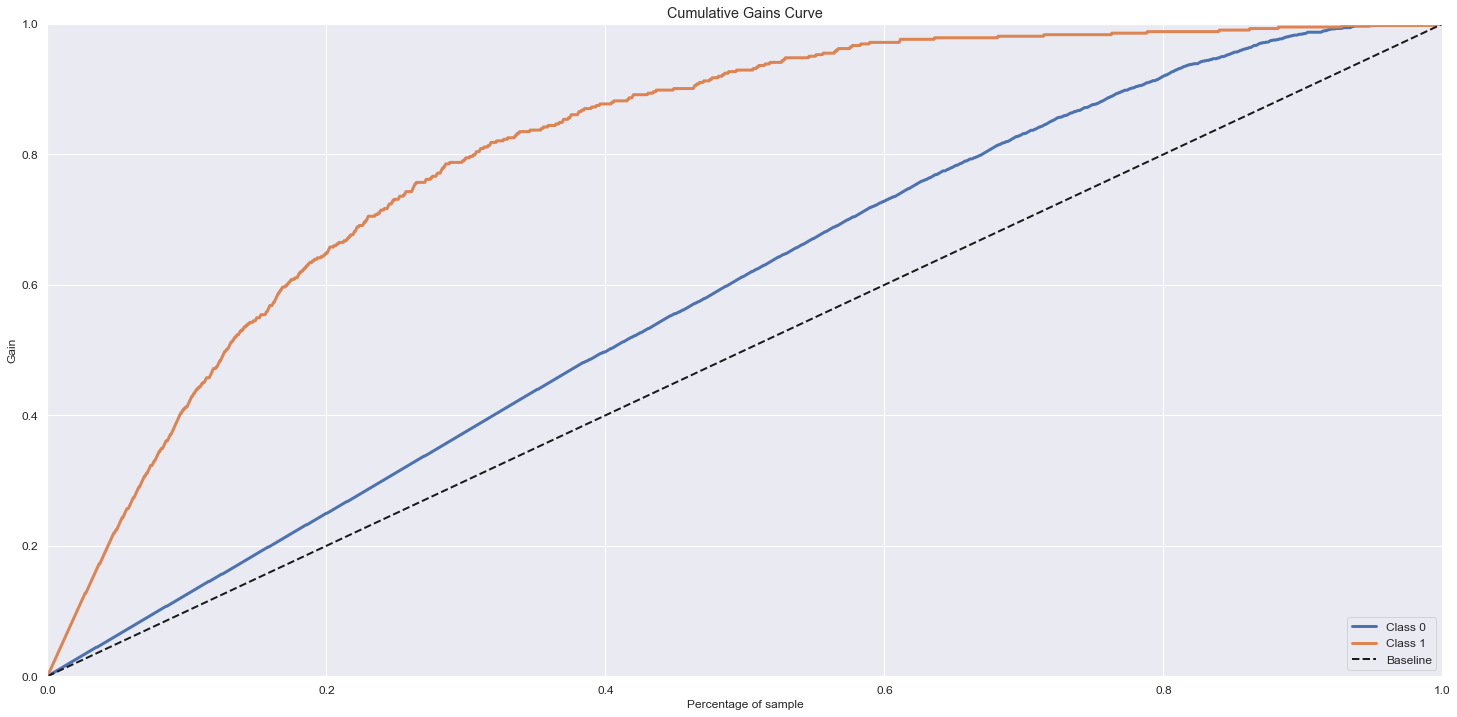

In [306]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

## 7.2 Logistic Regression

In [307]:
params = {
    'penalty':  ['l2', 'none'],
    'C':  [0.5, 1, 10, 100], 
    'solver': ['newton-cg', 'lbfgs', 'sag'],
    'class_weight': [None, 'balanced']
}

MAX_EVAL = 5

In [309]:
lr_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    lr_model =  lm.LogisticRegression( penalty = hp['penalty'],
                                       C= hp['C'],
                                       solver= hp['solver'],
                                       class_weight= hp['class_weight'],
                                     )
         
    lr_cv = cross_validation(df7 , lr_model,'Logistic Regression - '+str(i),5,2,200)
    
    lr_m = lr_m.append(lr_cv)
    print(lr_m)
    
    
lr_m

{'penalty': 'none', 'C': 0.5, 'solver': 'lbfgs', 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                        Mean_Precision_at_k   Mean_Recall_at_k
Logistic Regression - 0     0.758+/-0.02226  0.46276+/-0.01373
{'penalty': 'l2', 'C': 10, 'solver': 'lbfgs', 'class_weight': 'balanced'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                        Mean_Precision_at_k   Mean_Recall_at_k
Logistic Regression - 0     0.758+/-0.02226  0.46276+/-0.01373
Logistic Regression - 1    0.7435+/-0.03046  0.45389+/-0.01801
{'penalty': 'none', 'C': 10, 'solver': 'lbfgs', 'class_weight': None}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Nu

,Mean_Precision_at_k,Mean_Recall_at_k
Logistic Regression - 0,0.758+/-0.02226,0.46276+/-0.01373
Logistic Regression - 1,0.7435+/-0.03046,0.45389+/-0.01801
Logistic Regression - 2,0.756+/-0.02685,0.46154+/-0.01635
Logistic Regression - 3,0.748+/-0.02751,0.45665+/-0.01666
Logistic Regression - 4,0.7565+/-0.02789,0.46184+/-0.01703


In [310]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )

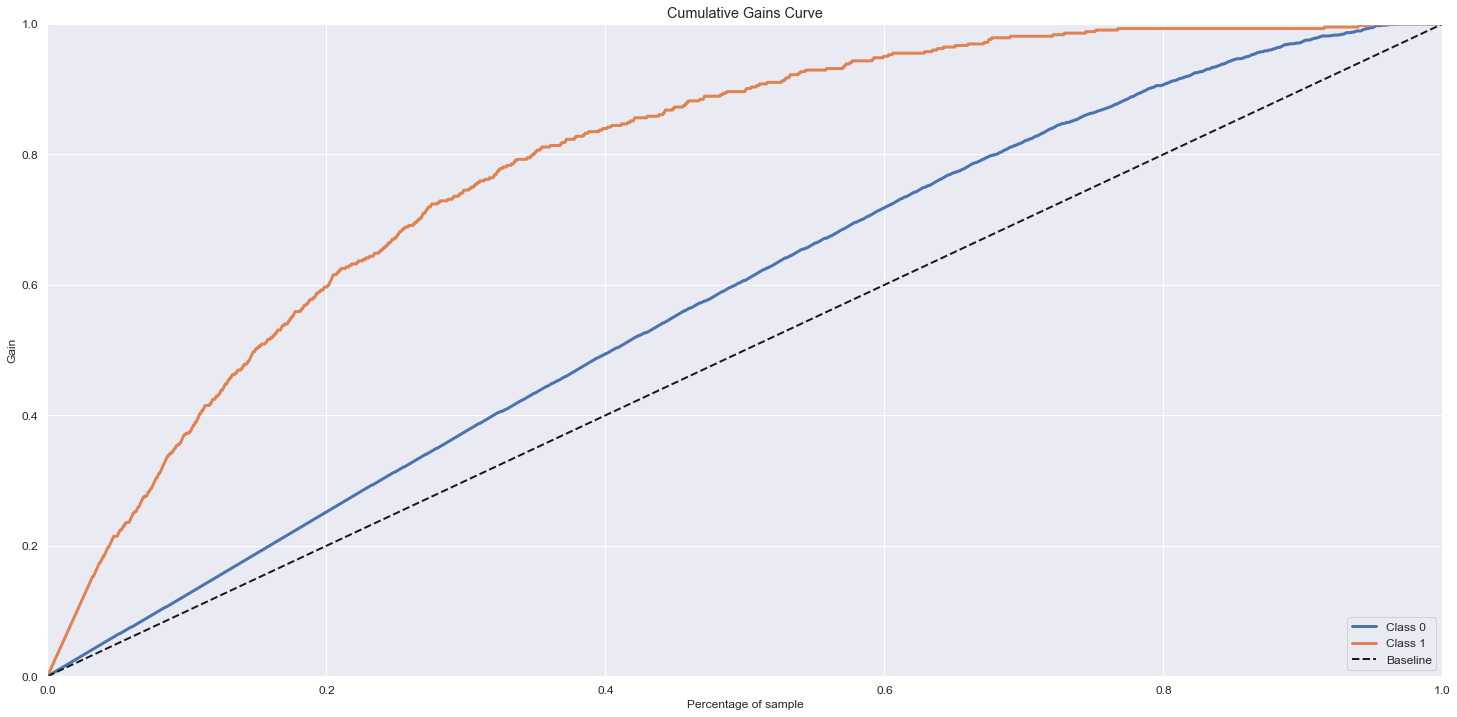

In [311]:
 # Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

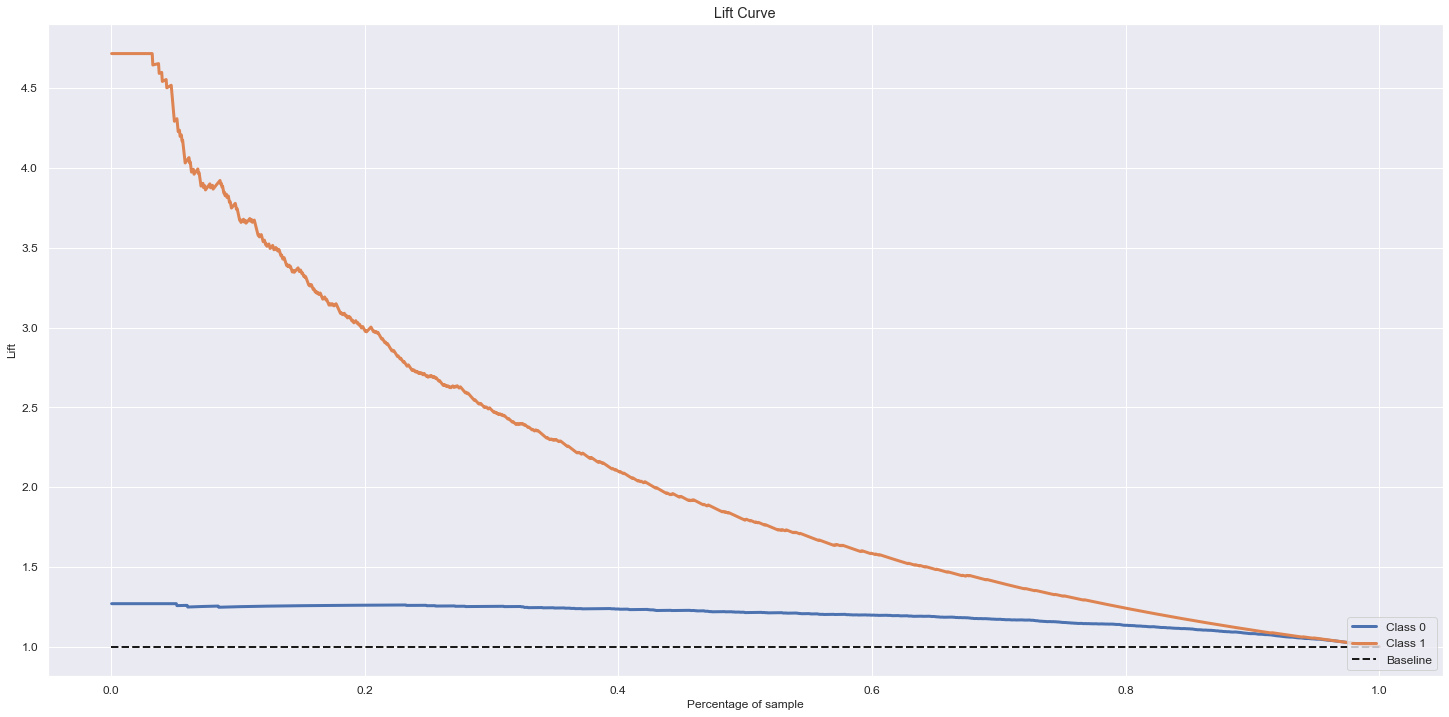

In [312]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr );

## 7.3 Extra trees Classifier

In [313]:
params = { 'n_estimators':[250,500,750],
           'max_depth':[3,5,7],
           'min_samples_split':  [2,3],
           'min_samples_leaf': [1,2],
           'class_weight': [None, 'balanced','balanced_subsample']
}

MAX_EVAL = 5

In [315]:
et_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    et_model = en.ExtraTreesClassifier(n_estimators = hp['n_estimators'],
                                       max_depth = hp['max_depth'],
                                       min_samples_split= hp['min_samples_split'],
                                       min_samples_leaf= hp['min_samples_leaf'],
                                       class_weight = hp['class_weight'],
                                       random_state = 25,
                                       n_jobs=-1)
         
    et_cv = cross_validation(df7,et_model,'Extra Trees Classifier - '+str(i),5,2,200)
    
    et_m = et_m.append(et_cv)
    print(et_m)
    
    
et_m

{'n_estimators': 250, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'class_weight': 'balanced'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0     0.794+/-0.02514  0.48474+/-0.01542
{'n_estimators': 750, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                           Mean_Precision_at_k   Mean_Recall_at_k
Extra Trees Classifier - 0     0.794+/-0.02514  0.48474+/-0.01542
Extra Trees Classifier - 1    0.7935+/-0.02495  0.48443+/-0.01508
{'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_

,Mean_Precision_at_k,Mean_Recall_at_k
Extra Trees Classifier - 0,0.794+/-0.02514,0.48474+/-0.01542
Extra Trees Classifier - 1,0.7935+/-0.02495,0.48443+/-0.01508
Extra Trees Classifier - 2,0.804+/-0.01468,0.49084+/-0.00886
Extra Trees Classifier - 3,0.7405+/-0.03468,0.45206+/-0.02082
Extra Trees Classifier - 4,0.7485+/-0.02224,0.45694+/-0.01297


In [317]:
# model definition
et = en.ExtraTreesClassifier( n_estimators=500, n_jobs=-1,
                              random_state=42, max_depth=7 ) 

# model training
et.fit( x_train, y_train )

# model prediction
yhat_et = et.predict_proba( x_val )

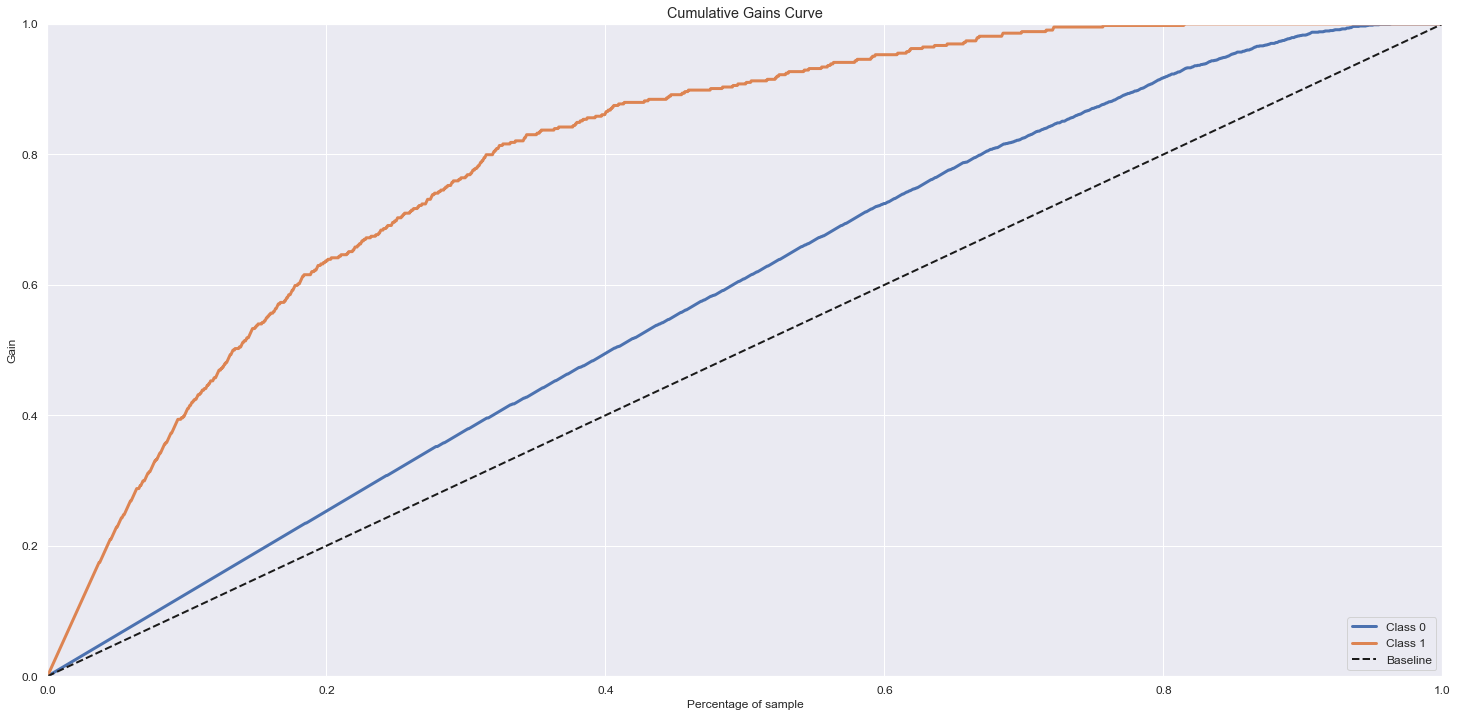

In [318]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_et );

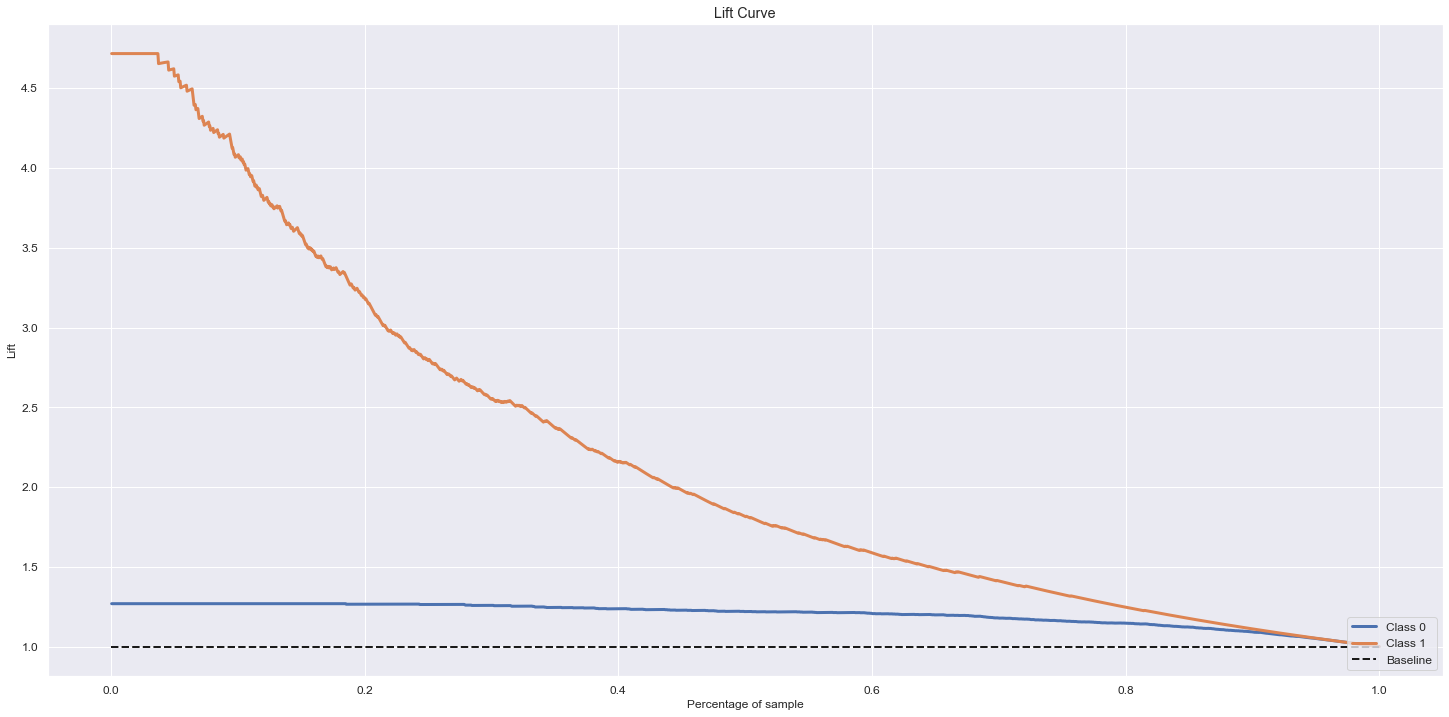

In [319]:
 #Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_et );

In [ ]:
'n_estimators': 500, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1, 'class_weight': 'balanced_subsample'

## 7.4 XGBoost Classifier

In [320]:
params = { 'n_estimators':  [100, 200, 300, 400, 500],
           'max_depth': [3,5,9], 
           'scale_pos_weight': [1,7.15, 100]
}

MAX_EVAL = 5

In [323]:
xgb_m = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    xgb_model = xgb.XGBClassifier(  objective='binary:logistic',
                                    n_estimators = hp['n_estimators'],
                                    max_depth = hp['max_depth'],
                                    scale_pos_weight = hp['scale_pos_weight'],
                                    n_jobs=-1)
         
    xgb_cv = cross_validation(df7,xgb_model,'XGBoost Classifier - '+str(i),5,2,200)
    
    xgb_m = xgb_m.append(xgb_cv)
    print(xgb_m)
    
    
xgb_m

{'n_estimators': 100, 'max_depth': 9, 'scale_pos_weight': 7.15}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0    0.7825+/-0.02336  0.47773+/-0.01463
{'n_estimators': 100, 'max_depth': 9, 'scale_pos_weight': 1}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold Number: 10
                       Mean_Precision_at_k   Mean_Recall_at_k
XGBoost Classifier - 0    0.7825+/-0.02336  0.47773+/-0.01463
XGBoost Classifier - 1    0.7845+/-0.03175  0.47893+/-0.01923
{'n_estimators': 300, 'max_depth': 9, 'scale_pos_weight': 100}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5

KFold Number: 6

KFold Number: 7

KFold Number: 8

KFold Number: 9

KFold 

,Mean_Precision_at_k,Mean_Recall_at_k
XGBoost Classifier - 0,0.7825+/-0.02336,0.47773+/-0.01463
XGBoost Classifier - 1,0.7845+/-0.03175,0.47893+/-0.01923
XGBoost Classifier - 2,0.78+/-0.03266,0.47619+/-0.01997
XGBoost Classifier - 3,0.783+/-0.02429,0.47803+/-0.01509
XGBoost Classifier - 4,0.7745+/-0.0265,0.47283+/-0.01617


In [324]:
# model definition
model_xgb = xgb.XGBClassifier(objective='binary:logistic',
                              random_state=17,
                              n_jobs=-1,
                              max_depth = 5,
                              n_estimators=300)

#model training
model_xgb.fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict_proba( x_val )

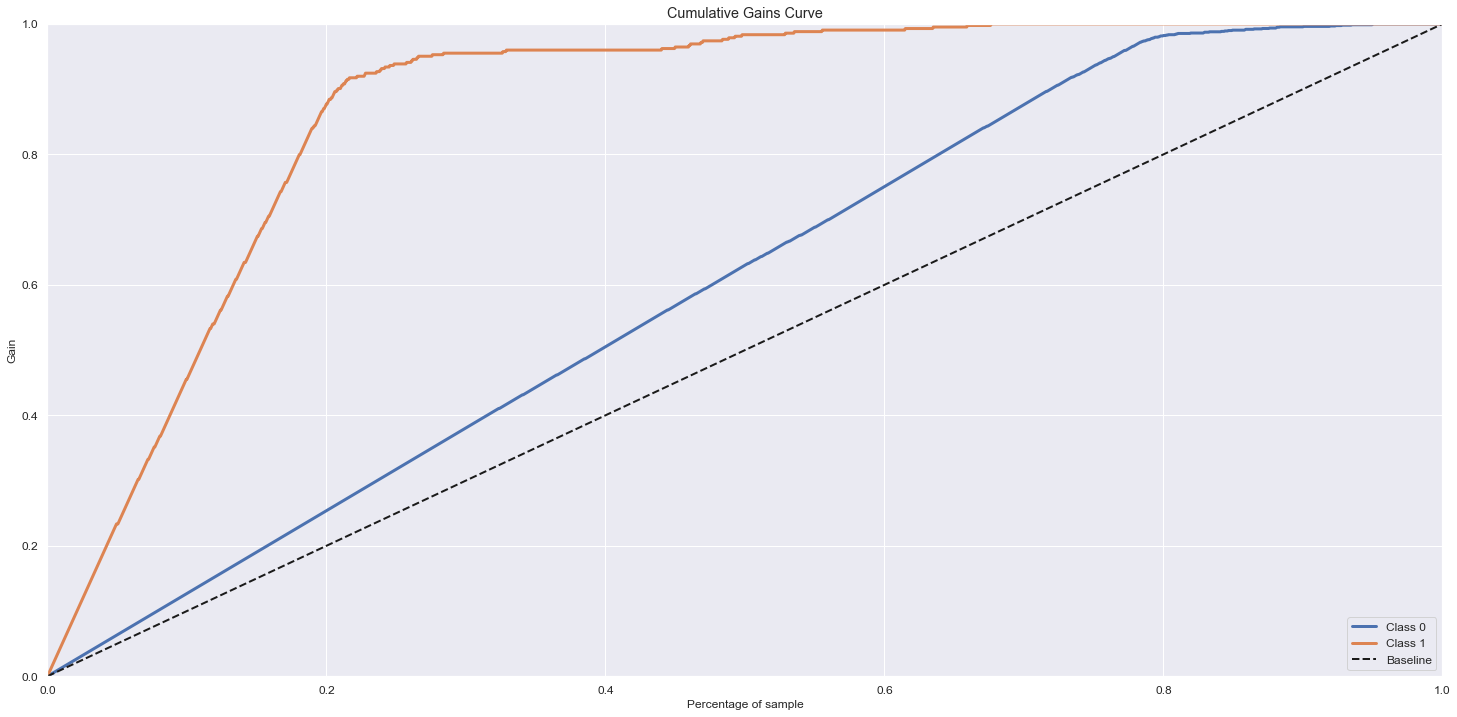

In [325]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb );

In [335]:
model_lgbm=LGBMClassifier(n_estimators=1100, n_jobs=-1, random_state=42)

#model training
model_lgbm.fit( x_train, y_train )

# prediction
yhat_lgbm = model_lgbm.predict_proba( x_val )

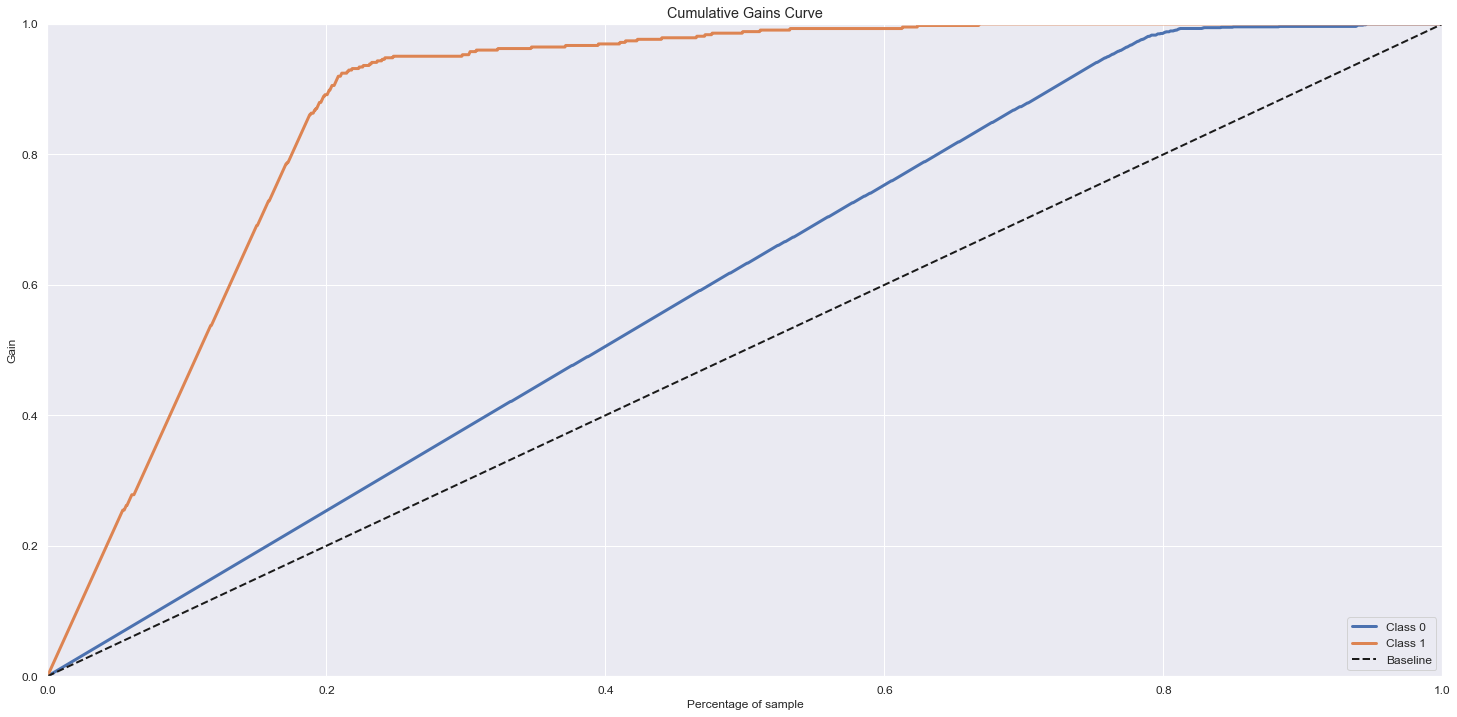

In [336]:
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );

# 8.0 Perfomance Metrics

# 9.0 Business Traduction

# 10.0 Deploy Model